# Introduction

After the data has been fetched from Twitter, it is required to maximize the quality of the data.
The definition of exclusion criteria aims to exclude those tweets which are not worthy to evaluate or might even bias the results. Those limitations can be categorized and addressed by the following defined exclusion criteria:

##### EC1 Data Basis
1. Removal of duplicates
2. Removal of Retweets
3. Removal of Quotes
4. Removal of Bot-generated Tweets

##### EC2 Data Quality
1. Tweet length
2. Entity ratio (Question: Does a single word tweet surrounded by multiple user mentions or URLs have any valuable information? Answer: Probably not)

The first category of exclusion criteria focuses on the problems resulted from the methodology of performed data collection process.
The data collection has been executed multiple times, thus a single tweet has been received not only once, but in some cases multiple times. This methodology problem can be sovled by removing all duplicate tweets. This process has been conducted in the last notebook, while storing only unique tweets.
Furthermore, some tweets are just retweets from other users and should not be counted as dedicated tweets in the data mining process.
Last but not least - and maybe the most important criteria - tweets generated by bots should be removed.
A first look on the data revealed a lot of spam in the data basis. This spam is automatically generated by computer programs and should be removed, as it highly bias the results of the analysis in the future.
Consider a data basis of 1000 tweets, if a single bot has published 1/2 of the tweets, all results are biased towards the content the bot is posting! And the content can not be valuable for the analysis, as it is automatically generated!


The second category of criteria aims on the quality of the received tweets.
For the purpose of sentiment analysis, we can distinguish between the quality of tweets.
Tweets only containing a few words does not provide any context for the analysis, thus they should be removed.
There are even tweets, which might have more than 100 characters in total, but a closer look shows that in some cases the length is just a result of URLs, mentioned users or other twitter specific entities.
This, these tweets also do not contain valuable information and should be removed

In [1]:
import json
import codecs
import pprint
import re
import os
import sys
import csv
import glob
import re
import json
import pandas as pd
from pprint import pprint
from pandas.io.json import json_normalize
import cPickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

In [2]:
with open('./data/processed/unique_all_tweets.pickle', 'rb') as f:
    data = pickle.load(f)

# Some Basic Analysis on the Distribution of Tweets

In [3]:
distribution = [d['category'] for k,d in data.iteritems()]
df_distribution = pd.DataFrame.from_dict(distribution)

## Tweets per Topic

,top_topic,Count
0,CarManufacturer,21782
1,FastFood,51816
2,Movies,84915
3,Musician,64284
4,Series,23334
5,Soccer,26579
6,Technology,78360
7,USPolitican,30246


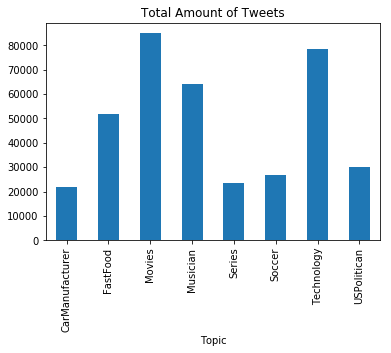

In [4]:
tweets_per_topic = df_distribution.groupby('top_topic').size()
tweets_per_topic.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Topic")
display(tweets_per_topic.reset_index(name="Count"))

## Tweets per Attitude

,attitude,Count
0,negative,156516
1,positive,224800


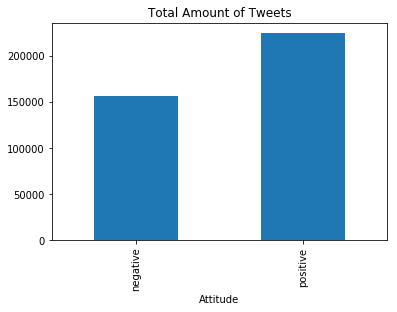

In [5]:
tweets_per_attitude = df_distribution.groupby('attitude').size()
tweets_per_attitude.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Attitude")
display(tweets_per_attitude.reset_index(name="Count"))

## Tweets per Topic and Attitude

attitude,negative,positive
top_topic,,
CarManufacturer,10369,11413
FastFood,20547,31269
Movies,54671,30244
Musician,39819,24465
Series,6184,17150
Soccer,7598,18981
Technology,12512,65848
USPolitican,4816,25430


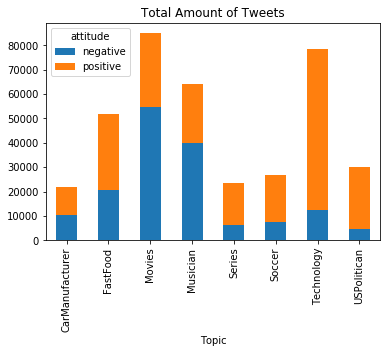

In [6]:
tweets_per_topic_attitude = df_distribution.groupby(['top_topic','attitude']).size().unstack()
tweets_per_topic_attitude.plot(kind='bar',stacked=True,title="Total Amount of Tweets").set_xlabel("Topic")
display(tweets_per_topic_attitude)

## Tweets per Topic and Attitude Normalized

attitude,negative,positive
top_topic,,
CarManufacturer,0.476035,0.523965
FastFood,0.396538,0.603462
Movies,0.643832,0.356168
Musician,0.619423,0.380577
Series,0.265021,0.734979
Soccer,0.285865,0.714135
Technology,0.159673,0.840327
USPolitican,0.159228,0.840772


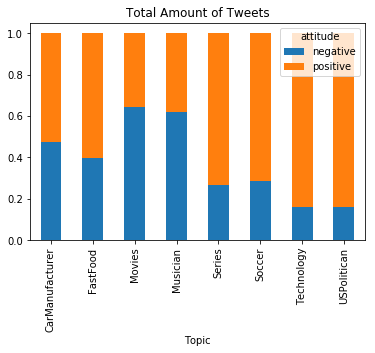

In [7]:
tweets_per_topic_attitude = df_distribution.groupby(['top_topic','attitude']).size().unstack()
tweets_per_topic_attitude["total"] = tweets_per_topic_attitude["negative"] + tweets_per_topic_attitude["positive"]
tweets_per_topic_attitude["negative"] = tweets_per_topic_attitude["negative"] / tweets_per_topic_attitude["total"]
tweets_per_topic_attitude["positive"] = tweets_per_topic_attitude["positive"] / tweets_per_topic_attitude["total"]
del tweets_per_topic_attitude["total"]

tweets_per_topic_attitude.plot(kind='bar',stacked=True,title="Total Amount of Tweets").set_xlabel("Topic")
display(tweets_per_topic_attitude)

# Filtering Tweets

Filtering the Tweets based on the described exclusion criteria in the first part of this notebook

In [8]:
def isRetweet(tweet):
    """Check if tweet is a Retweet"""
    if tweet['full_text'].startswith("RT"):
        return True
    else:
        return False

def isQuote(tweet):
    """Check if tweet is a quote from a different tweet"""
    if tweet['is_quote_status']:
        return True 
    else:
        return False

def isReply(tweet):
    """Check if tweet is a reply to a different tweet"""
    if tweet['in_reply_to_status_id']:
        return True
    else:
        return False

def isOutlier(tweet):
    """
    Check if Tweet is an outlier, based on the ratio of hashtags,urls,media, etc. to plain text
    A 'outlier' is defined as a tweet, which only has 25% of plain text compared to the full length.
    75% of the tweet are twitter specific entities like hashtags, urls, media, mentioned_users, etc.
    Or if the plain text length is less than 15 characters
    """
    #first calculate the sum of twitter specific characters
    hashtag_length = sum(len(x['text'])+2 for x in tweet.get('entities',{}).get('hashtags',[]))
    urls_length = sum(len(x['display_url'])+2 for x in tweet.get('entities',{}).get('urls',[]))
    media_length = sum(len(x['display_url'])+2 for x in tweet.get('entities',{}).get('media',[]))
    user_mentions_length = sum(len(x['screen_name'])+2 for x in tweet.get('entities',{}).get('user_mentions',[]))
    total_entities_length = hashtag_length+urls_length+media_length+user_mentions_length
    tweet_length = len(tweet['full_text'].replace(" ", ""))
    ratio = total_entities_length*1.0/tweet_length
    stripped_length = tweet_length-total_entities_length
    if ratio >= 0.75 or stripped_length<15:
        return True,tweet_length,total_entities_length,stripped_length,ratio
    else:
        return False,tweet_length,total_entities_length,stripped_length,ratio
 
for tweet_id,tweet in data.iteritems():
    outlier_stats = isOutlier(tweet)
    data[tweet_id]['stats'] = {
        'isRetweet':isRetweet(tweet),
        'isQuote':isQuote(tweet),
        'isReply':isReply(tweet),
        'isOutlier':outlier_stats[0],
        'text_length':outlier_stats[1],
        'text_entities_length':outlier_stats[2],
        'text_plaintext_length':outlier_stats[3],
        'text_plaintext_ratio':outlier_stats[4]
    }
    
    #check if the tweet should be filtered. For the further processing, only tweets which are no retweets, no quotes and no outlier should be considered
    filtered = False
    if tweet['stats']['isRetweet'] or tweet['stats']['isQuote'] or tweet['stats']['isOutlier']:
        filtered=True
    tweet['stats']['filtered'] = filtered

In [9]:
stats = [d['stats'] for k,d in data.iteritems()]
df_stats = pd.DataFrame.from_dict(stats)

## ReTweets 

,isRetweet,Count
0,False,170177
1,True,211139


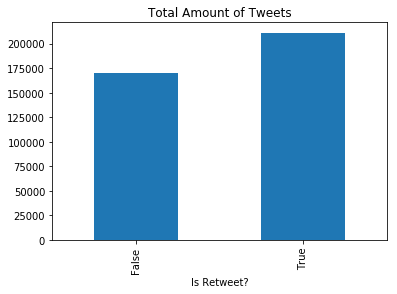

In [10]:
tweets_per_retweet = df_stats.groupby('isRetweet').size()
tweets_per_retweet.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Is Retweet?")
display(tweets_per_retweet.reset_index(name="Count"))

## Quotes

,isQuote,Count
0,False,362113
1,True,19203


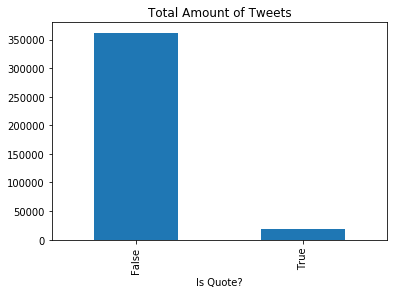

In [11]:
tweets_per_quote = df_stats.groupby('isQuote').size()
tweets_per_quote.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Is Quote?")
display(tweets_per_quote.reset_index(name="Count"))

## Replies

,isReply,Count
0,False,306810
1,True,74506


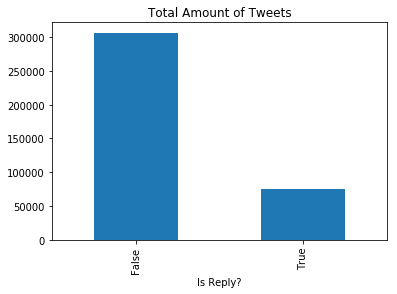

In [12]:
tweets_per_reply = df_stats.groupby('isReply').size()
tweets_per_reply.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Is Reply?")
display(tweets_per_reply.reset_index(name="Count"))

## Filtered Tweets

,filtered,Count
0,False,151952
1,True,229364


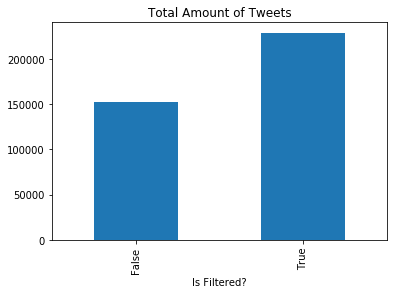

In [13]:
tweets_per_filtered = df_stats.groupby('filtered').size()
tweets_per_filtered.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Is Filtered?")
display(tweets_per_filtered.reset_index(name="Count"))

# Check for Tweet Source

To check for the tweet origin, the "source" property will be used.
It contains HTML of the source. In order to extract the relevant information, the markup will be parsed and transformed into a schema for further processing.

In a first step, all sources are extracted and ordered by the amount of appearance to get an overview.
Afterwards, the list of whitelisted source is successive shortlisted by an iterative evaluation and further short listing.

At the end, only source, which are probably connected to user-generated content, are used for the further project.

In [14]:
#checking for sources
from IPython.display import display, HTML
from bs4 import BeautifulSoup

all_sources = pd.DataFrame()
all_sources['source'] = [tweet['source'] for tweet_id,tweet in data.iteritems()]
all_sources = all_sources.groupby('source').size().reset_index(name='count')

all_sources_formatted = []
for idx,row in all_sources.iterrows():
    temp_dict = {}
    url = row['source']
    temp_dict['raw'] = url
    if isinstance(url,basestring):
        soup = BeautifulSoup(url,"lxml")
        temp_dict['name'] = soup.text
        temp_dict['url'] = soup.find('a')['href']
    else:
        temp_dict['name'] = url
        temp_dict['url'] = url
    temp_dict['count'] = row['count']
    all_sources_formatted.append(temp_dict)
#        
df_sources = pd.DataFrame.from_dict(all_sources_formatted).sort_values(['count'],ascending=False)
HTML(df_sources.to_html())

,count,name,raw,url
496,160706,Twitter for iPhone,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone
495,100282,Twitter for Android,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android
481,66812,Twitter Web Client,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com
1160,10964,Twitter Lite,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com
953,6152,TweetDeck,"<a href=""https://about.twitter.com/products/tw...",https://about.twitter.com/products/tweetdeck
486,6045,Twitter for iPad,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://twitter.com/#!/download/ipad
626,4643,Facebook,"<a href=""http://www.facebook.com/twitter"" rel=...",http://www.facebook.com/twitter
1113,2122,IFTTT,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",https://ifttt.com
1524,1802,Sprinklr,"<a href=""https://www.sprinklr.com"" rel=""nofoll...",https://www.sprinklr.com
479,1737,twittbot.net,"<a href=""http://twittbot.net/"" rel=""nofollow"">...",http://twittbot.net/


In [15]:
#filter to only tweets with "twitter.com" in source
df_sources_filtered = df_sources[df_sources['url'].str.contains("twitter.com",na=False)]
HTML(df_sources_filtered.head(n=100).to_html())

,count,name,raw,url
496,160706,Twitter for iPhone,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone
495,100282,Twitter for Android,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android
481,66812,Twitter Web Client,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com
1160,10964,Twitter Lite,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com
953,6152,TweetDeck,"<a href=""https://about.twitter.com/products/tw...",https://about.twitter.com/products/tweetdeck
486,6045,Twitter for iPad,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://twitter.com/#!/download/ipad
1159,659,Mobile Web (M2),"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com
897,234,Twitter for Windows,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com
896,98,Twitter for Windows Phone,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com
895,96,Twitter for BlackBerry,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com


In [16]:
#expand filtering 
df_sources_filtered_expanded = df_sources[(df_sources['url'].str.endswith("twitter.com",na=False) | df_sources['url'].str.contains("twitter.com/download",na=False) )]
HTML(df_sources_filtered_expanded.to_html())

,count,name,raw,url
496,160706,Twitter for iPhone,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone
495,100282,Twitter for Android,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android
481,66812,Twitter Web Client,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com
1160,10964,Twitter Lite,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com
1159,659,Mobile Web (M2),"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com
897,234,Twitter for Windows,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com
896,98,Twitter for Windows Phone,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com
895,96,Twitter for BlackBerry,"<a href=""http://www.twitter.com"" rel=""nofollow...",http://www.twitter.com
955,39,Twitter Ads Composer,"<a href=""https://ads-api.twitter.com"" rel=""nof...",https://ads-api.twitter.com
1068,28,Gamicity,"<a href=""https://gamicitytwitter.com"" rel=""nof...",https://gamicitytwitter.com


## Combine the Previous Filtering and the "Bot Analysis"

In [17]:
no_bots = list(df_sources_filtered_expanded['raw'])
def isBot(tweet):
    if tweet['source'] not in no_bots:
        return True
    else:
        return False
    
for tweet_id,tweet in data.iteritems():
    tweet['stats']['isBot'] = isBot(tweet)

In [18]:
stats = [d['stats'] for k,d in data.iteritems()]
df_stats = pd.DataFrame.from_dict(stats)

,filtered,Count
0,False,123457
1,True,257859


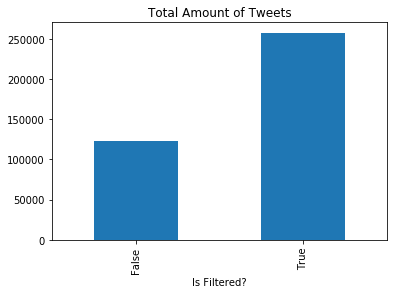

In [19]:
df_stats['filtered'] = df_stats['isBot'] | df_stats['isOutlier'] | df_stats['isRetweet'] | df_stats['isQuote']
final_filtered = df_stats.groupby('filtered').size()
final_filtered.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Is Filtered?")
display(final_filtered.reset_index(name="Count"))

## Deep Dive Analysis on Filtering Reasons
Take a closer look on the application of the different filtering reasons

,0
isQuote,19203
isBot,41377
isRetweet,211139
isOutlier,19203


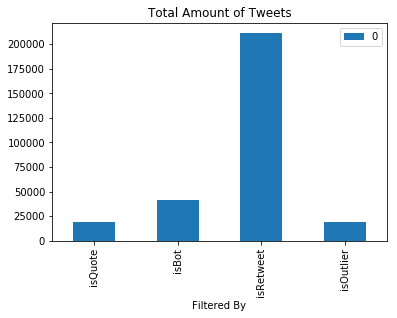

In [20]:
df_stats_filter_analysis = df_stats[['isBot','isOutlier','isQuote','isRetweet']]
temp = df_stats_filter_analysis.groupby(['isBot','isOutlier','isQuote','isRetweet']).size().reset_index(name="count")
temp_dict = {
    "isBot":temp.groupby(['isBot'])['count'].sum()[True],
    "isRetweet":temp.groupby(['isRetweet'])['count'].sum()[True],
    "isQuote":temp.groupby(['isQuote'])['count'].sum()[True],
    "isOutlier":temp.groupby(['isQuote'])['count'].sum()[True] 
}
df_filter_analysis = pd.DataFrame.from_dict(temp_dict,orient="index")
df_filter_analysis.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Filtered By")
display(df_filter_analysis)

# Analyze the Final Filtered Tweets
After all filtering has been done, this analysis aims to get a better understanding of final selection.
It is similar to the analysis and visualization at the top of this notebook

In [21]:
#Build a helper dictionary with the required information for the analysis
stats_category = [{'stats':d['stats'],'category':d['category']} for k,d in data.iteritems()]
df_stats_category = json_normalize(stats_category)

Recalculate the filtering and filter the data frame to the final selection

In [28]:
df_stats_category['filtered'] = df_stats['isBot'] | df_stats['isOutlier'] | df_stats['isRetweet'] | df_stats['isQuote']
df_stats_category_filtered = df_stats_category[df_stats_category['filtered']==False]
df_stats_category_filtered.dtypes

category.attitude               object
category.seed_topic             object
category.top_topic              object
stats.filtered                    bool
stats.isBot                       bool
stats.isOutlier                   bool
stats.isQuote                     bool
stats.isReply                     bool
stats.isRetweet                   bool
stats.text_entities_length       int64
stats.text_length                int64
stats.text_plaintext_length      int64
stats.text_plaintext_ratio     float64
filtered                          bool
dtype: object

## Tweets per Topic (Filtered)

,category.top_topic,Count
0,CarManufacturer,10147
1,FastFood,22849
2,Movies,21087
3,Musician,8953
4,Series,10089
5,Soccer,11411
6,Technology,27383
7,USPolitican,11538


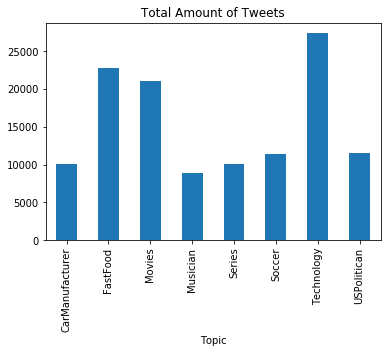

In [23]:
tweets_per_topic = df_stats_category_filtered.groupby('category.top_topic').size()
tweets_per_topic.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Topic")
display(tweets_per_topic.reset_index(name="Count"))

## Tweets per Attitude (Filtered)

,category.attitude,Count
0,negative,40516
1,positive,82941


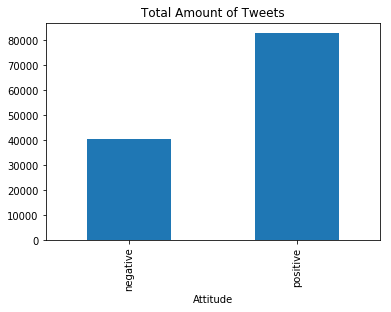

In [24]:
tweets_per_attitude = df_stats_category_filtered.groupby('category.attitude').size()
tweets_per_attitude.plot(kind='bar',title="Total Amount of Tweets").set_xlabel("Attitude")
display(tweets_per_attitude.reset_index(name="Count"))

## Tweets per Topic and Attitude

category.attitude,negative,positive
category.top_topic,,
CarManufacturer,4389,5758
FastFood,10391,12458
Movies,8224,12863
Musician,2471,6482
Series,3490,6599
Soccer,2919,8492
Technology,6622,20761
USPolitican,2010,9528


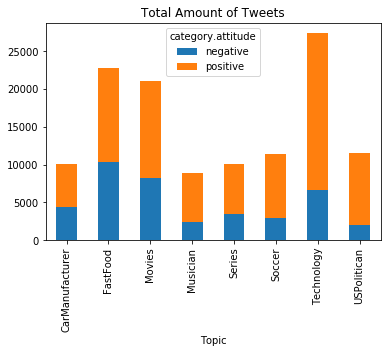

In [25]:
tweets_per_topic_attitude = df_stats_category_filtered.groupby(['category.top_topic','category.attitude']).size().unstack()
tweets_per_topic_attitude.plot(kind='bar',stacked=True,title="Total Amount of Tweets").set_xlabel("Topic")
display(tweets_per_topic_attitude)

## Tweets per Topic and Attitude Normalized

category.attitude,negative,positive
category.top_topic,,
CarManufacturer,0.432542,0.567458
FastFood,0.454768,0.545232
Movies,0.390003,0.609997
Musician,0.275997,0.724003
Series,0.345921,0.654079
Soccer,0.255806,0.744194
Technology,0.241829,0.758171
USPolitican,0.174207,0.825793


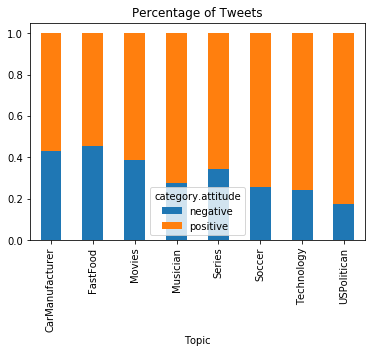

In [26]:
tweets_per_topic_attitude = df_stats_category_filtered.groupby(['category.top_topic','category.attitude']).size().unstack()
tweets_per_topic_attitude["total"] = tweets_per_topic_attitude["negative"] + tweets_per_topic_attitude["positive"]
tweets_per_topic_attitude["negative"] = tweets_per_topic_attitude["negative"] / tweets_per_topic_attitude["total"]
tweets_per_topic_attitude["positive"] = tweets_per_topic_attitude["positive"] / tweets_per_topic_attitude["total"]
del tweets_per_topic_attitude["total"]

tweets_per_topic_attitude.plot(kind='bar',stacked=True,title="Percentage of Tweets").set_xlabel("Topic")
display(tweets_per_topic_attitude)

# Export to Filtered File

In [27]:
#filter the complete dictionary
filtered = {k: v for k, v in data.iteritems() if v['stats']['isBot']==False and v['stats']['isOutlier']==False and v['stats']['isRetweet']==False and v['stats']['isQuote']==False}
print(len(filtered))
#import cPickle as pickle
with open('./data/processed/unique_all_tweets_filtered.pickle', 'wb') as f:
    pickle.dump(filtered, f, 2)

123457
